Candidate: Kumutha S.Ramachanidran
#
Date: 12/01/2023
#
Assessment: 4
#
1. Link to the source of data:
https://www.kaggle.com/competitions/data-science-bowl-2018/overview
2. Link to the dataset (please use this as your data):
data-science-bowl-2018.zip
3. Carry out the whole machine learning workflow for this project (Problem
Formulation →Data Preparation→Model Development→Model
Deployment)
4. For criteria, try to achieve training and validation accuracy of more than 80%
5. Make sure your model is not overfitting.
6. Build a U-Net for this project (for downsampling path, you can apply transfer
learning, then build your own upsampling path similarly as what we did in the
exercise).

Git: 

In [149]:
#importing important libraries and modules
import cv2, os 
import random
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt 
import tensorflow_datasets as tfds
from IPython.display import clear_output
from tensorflow.keras import callbacks
from tensorflow_examples.models.pix2pix import pix2pix


In [119]:
#data preparation 
root_path = r"C:\Users\User\Desktop\Assessment\Assessment_4\data-science-bowl-2018-2\train"

In [120]:
#prepare empty list to hold the data 
inputs =[] 
masks = [] 

In [121]:
#loading images using opencv by creating a variable first 
image_dir = os.path.join(root_path,'inputs')
#to store all the images from images folder
for image_file in os.listdir(image_dir): 
    img = cv2.imread(os.path.join(image_dir,image_file))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(128,128))
    inputs.append(img)


In [122]:
#to load the masks
masks_dir = os.path.join(root_path,'masks')
for mask_file in os.listdir(masks_dir):
    mask = cv2.imread(os.path.join(masks_dir,mask_file),cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(128,128))
    masks.append(mask)



In [123]:
#to convert list to np array 
import numpy as np
inputs_np = np.array(inputs)
masks_np = np.array(masks)

In [124]:
#data preprocessing 
#expand the mask dimension
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#checking the mask output
print(np.unique(masks_np_exp[0]))

[  0  64 128 191 255]


In [125]:
#convert label to class label into [0,1]
converted_masks = np.round(masks_np_exp / 255.0).astype(np.int64)
#to check the mask output
print(np.unique(converted_masks[0]))


[0 1]


In [126]:
converted_inputs = inputs_np / 255.0 

In [127]:
from sklearn.model_selection import train_test_split
SEED = 42 
X_train, X_test, y_train, y_test = train_test_split(converted_inputs, converted_masks,test_size=0.2,random_state=SEED)

In [128]:
#convert the numpy arrays into tensor slices
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor =  tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor =  tf.data.Dataset.from_tensor_slices(y_test)

In [129]:
#combine the images and masks using the zip method
train_dataset = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test_dataset = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [130]:
#define hyperparameters for tensorflow dataset
TRAIN_SIZE = len(train_dataset)
BATCH_SIZE = 16
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

In [131]:
#define data augmentation pipeline as a single layer through subclassing
class Augment(keras.layers.Layer):
    def __init__(self,seed=42):
        super().__init__()
        self.augment_inputs = keras.layers.RandomFlip(mode= 'horizontal', seed=seed)
        self.augment_labels = keras.layers.RandomFlip(mode= 'horizontal', seed=seed)
    def call(self,inputs,labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels



In [132]:
#build the datasets
train_batches = (train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

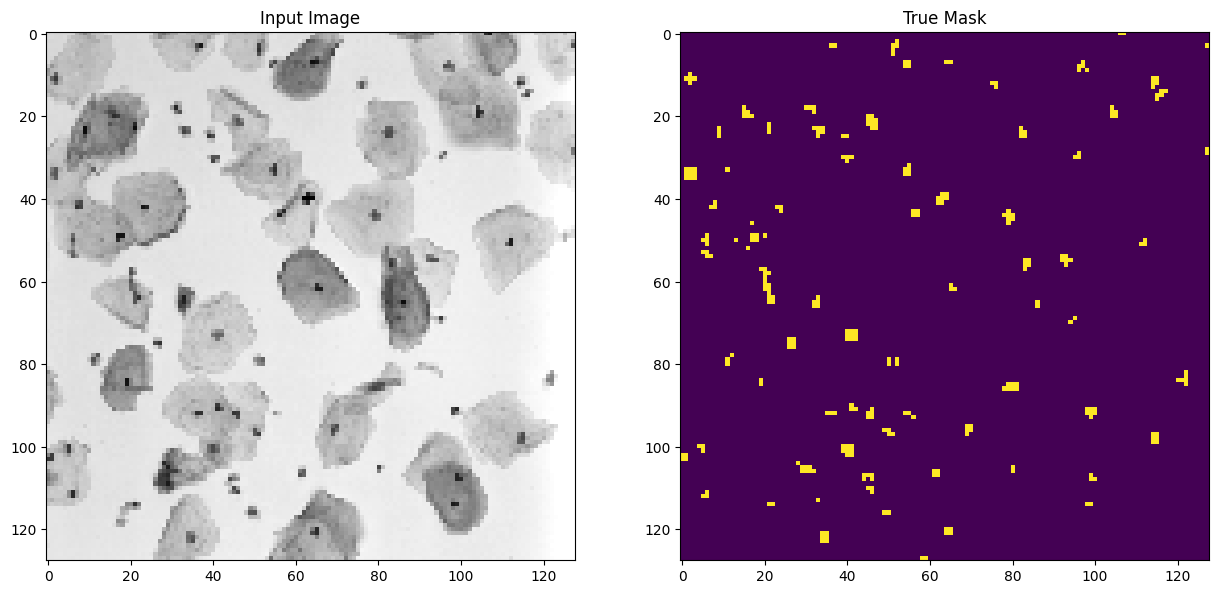

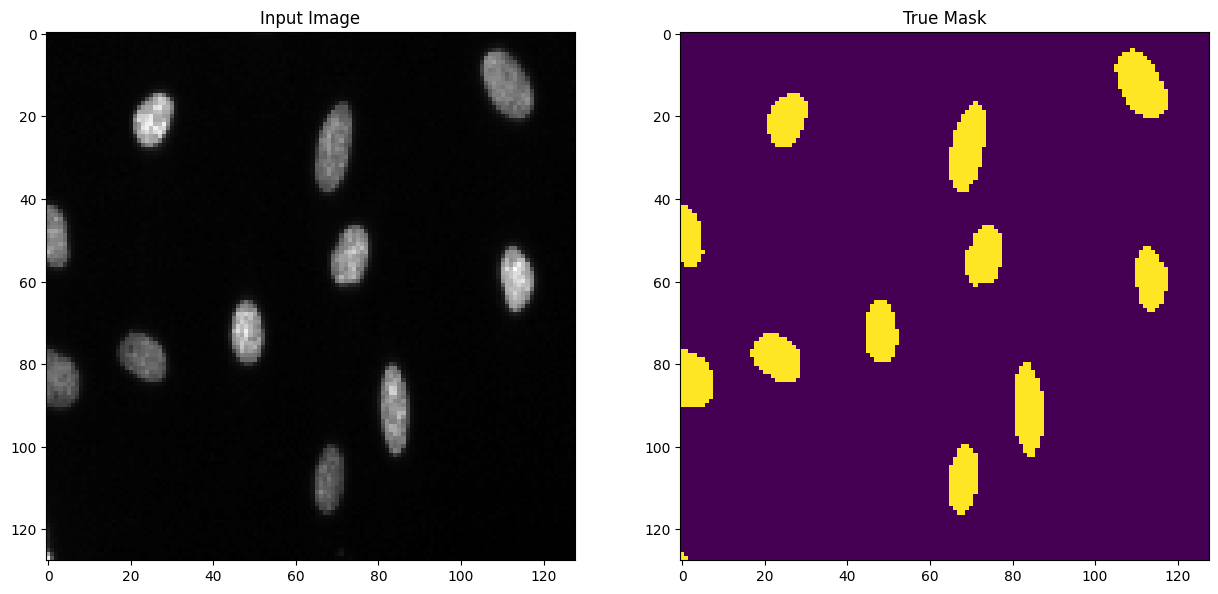

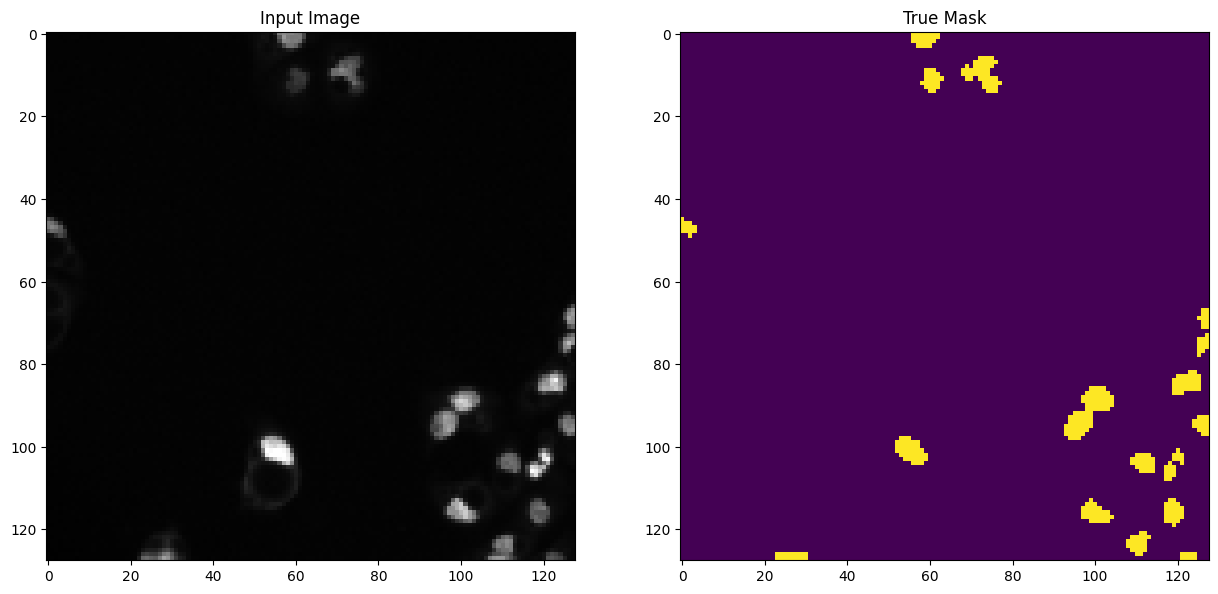

In [133]:
#visualize picture/images 
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range (len(display_list)):
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]))
    plt.show()

for images,masks in train_batches.take(3):
    sample_image,sample_mask = images[0],masks[0]
    display([sample_image,sample_mask])


In [134]:
#model development 
#using pretrained model for feature extractor 
base_model = keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)
base_model.summary()

#use activation layers as the output from the feature extractor 
layer_names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu','block_13_expand_relu','block_16_project']

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]



Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_23[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [135]:
label_class = 1

In [136]:
#Build the model
inputs = tf.keras.layers.Input((128, 128, 3))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(label_class, (1, 1), activation='sigmoid')(u9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 128, 128, 16  448         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_15 (Dropout)           (None, 128, 128, 16  0           ['conv2d_32[0][0]']              
                                )                                                           

In [137]:
#create the tensorboard callback
import datetime

log_path = os.path.join('log_dir', 'tl_demo', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(log_dir=log_path)

model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=64, epochs=10, callbacks=tb)

Epoch 1/10
8/8 [==============================] - 21s 2s/step - loss: 0.6702 - accuracy: 0.7455 - val_loss: 0.6596 - val_accuracy: 0.7681
Epoch 2/10
8/8 [==============================] - 25s 3s/step - loss: 0.5341 - accuracy: 0.8613 - val_loss: 1.7672 - val_accuracy: 0.4405
Epoch 3/10
8/8 [==============================] - 22s 3s/step - loss: 0.4723 - accuracy: 0.8780 - val_loss: 1.6804 - val_accuracy: 0.5547
Epoch 4/10
8/8 [==============================] - 21s 3s/step - loss: 0.4320 - accuracy: 0.8912 - val_loss: 1.2627 - val_accuracy: 0.6598
Epoch 5/10
8/8 [==============================] - 20s 3s/step - loss: 0.4044 - accuracy: 0.9022 - val_loss: 0.9236 - val_accuracy: 0.7132
Epoch 6/10
8/8 [==============================] - 23s 3s/step - loss: 0.3748 - accuracy: 0.9132 - val_loss: 0.5943 - val_accuracy: 0.8281
Epoch 7/10
8/8 [==============================] - 23s 3s/step - loss: 0.3457 - accuracy: 0.9232 - val_loss: 0.5265 - val_accuracy: 0.8606
Epoch 8/10
8/8 [==================

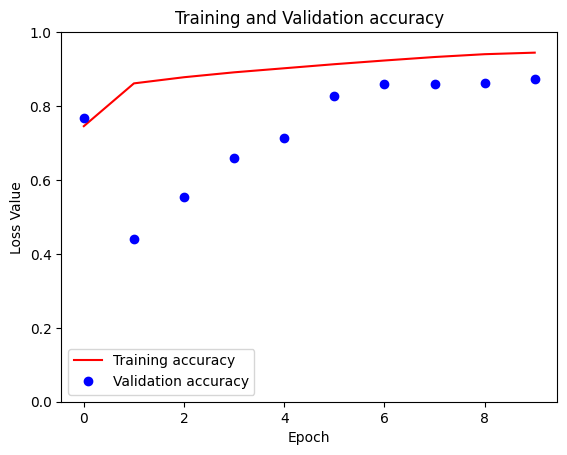

In [138]:
#display training and validation accuracy
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [139]:
#function to display input,mask and predicted images
def display_inputs(display_list):
  plt.figure(figsize=(7, 7))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [146]:
# to randomly choose images 
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.45).astype(np.uint8)

1/1 [==============================] - 0s 40ms/step


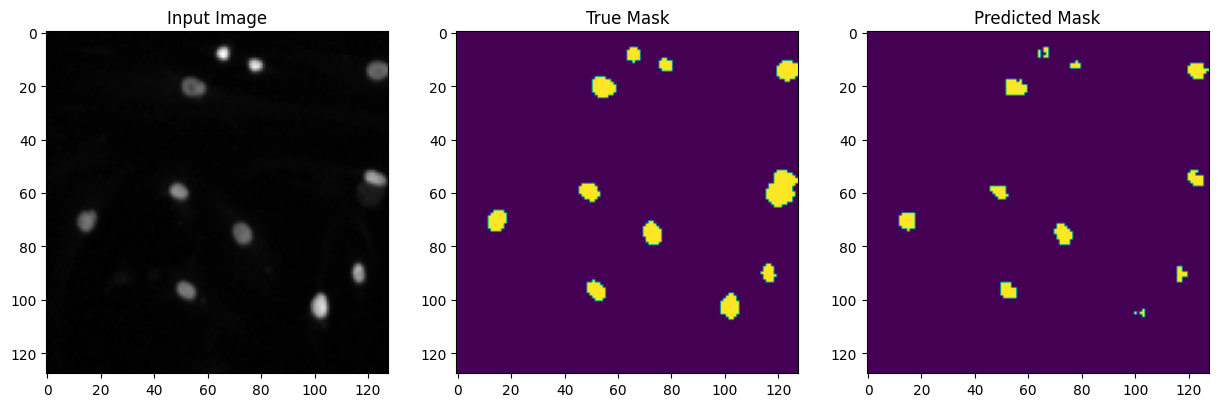

In [147]:
#display the input,true and predicted images of nuclei
display([sample_image, sample_mask,predicted_mask])

In [148]:
#to save trained model 
model.save('image_segmentation.h5')